In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn import *
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

import itertools
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import des bases de données

In [3]:
countries_selected = ["DEU", "ESP", "FRA", "GBR", "ITA", "USA"]
variables_EUKlems_selected = ["VA", "EMP"] # J'exclus COMP et LAB et GO
codes_selected = ["A", "B", "C10-C12", "C13-C15", "C16-C18", "C19", "C20", "C21", "C22_C23", "C24_C25", "C26", "C27", "C28", "C29_C30", "C31-C33", "D", "E", "G45", "G46", "G47", "H49", "H50", "H51", "H52", "H53", "I", "J58-J60", "J61", "J62_J63", "L", "M_N", "O", "P", "Q", "R", "S", "T", "U", "TOT"]
dates_selected = range(1990, 2020)

## Statistiques macroéconomiques
### EUKlems

In [4]:
# Import des bases en ligne
EUKlems_Growth = pd.read_csv("http://euklems.eu/bulk/Statistical_Growth-Accounts.csv")
EUKlems_Nat_Accounts = pd.read_csv("http://euklems.eu/bulk/Statistical_National-Accounts.csv")
EUKlems_Capital = pd.read_csv("http://euklems.eu/bulk/Statistical_Capital.csv")
EUKlems = pd.concat([EUKlems_Growth, EUKlems_Nat_Accounts, EUKlems_Capital], sort=False)

# Suppression colonnes inutiles
EUKlems = EUKlems.drop(['db', "Sort_ID", "indnr"], axis='columns')

# Récupérer les iso3code dans une table externe pour faciliter la fusion.
EUKlems["country"]=EUKlems["country"].replace("UK","GB")
referentiel_pays = pd.read_csv("data/country_label.csv", sep=";")
EUKlems = EUKlems.merge(referentiel_pays,on="country",how="outer") # Récupérer les iso3code
EUKlems = EUKlems.drop("country", axis='columns')

# Filtrage
EUKlems = EUKlems[EUKlems["var"].isin(variables_EUKlems_selected) 
                  & EUKlems["iso3code"].isin(countries_selected)
                  & EUKlems["code"].isin(codes_selected)]
EUKlems.head()

,var,code,1995,1996,1997,1998,1999,2000,2001,2002,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,iso3code
22579,EMP,TOT,37958.0,37969.0,37947.0,38407.0,39031.0,39917.0,39809.0,39630.0,...,40892.0,41020.0,41577.0,42061.0,42319.0,42671.0,43071.0,43642.0,44269.000000,DEU
22582,EMP,A,866.0,809.0,785.0,779.0,773.0,758.0,724.0,707.0,...,667.0,661.0,670.0,667.0,641.0,649.0,637.0,619.0,616.000000,DEU
22583,EMP,B,182.0,167.0,146.0,136.0,126.0,120.0,100.0,98.0,...,74.0,71.0,68.0,67.0,63.0,62.0,58.0,55.0,52.000000,DEU
22585,EMP,C10-C12,852.0,849.0,858.0,889.0,903.0,925.0,921.0,928.0,...,923.0,922.0,922.0,925.0,922.0,923.0,930.0,935.0,944.144095,DEU
22586,EMP,C13-C15,357.0,329.0,305.0,292.0,276.0,268.0,257.0,236.0,...,166.0,160.0,162.0,160.0,158.0,156.0,154.0,153.0,155.418595,DEU


In [5]:
# Pivotage
EUKlems_pivote = EUKlems.melt(id_vars=["var", "code", "iso3code"], var_name="year")
EUKlems_pivote["year"] = EUKlems_pivote["year"].astype("int")
EUKlems_pivote = EUKlems_pivote.pivot_table(index=["iso3code", "code", "year"], columns="var", values="value").reset_index()
EUKlems_pivote.head()

var,iso3code,code,year,EMP,VA
0,DEU,A,1995,866.0,17975.0
1,DEU,A,1996,809.0,19119.0
2,DEU,A,1997,785.0,19336.0
3,DEU,A,1998,779.0,18801.0
4,DEU,A,1999,773.0,18850.0


In [6]:
table_full = EUKlems_pivote

### OECD - CPI (non-food, non-energy, index 2015)

In [7]:
OECD_CPI = pd.read_csv("data/CPI.csv", sep=";")
OECD_CPI[OECD_CPI["iso3code"]=="FRA"].head()

,iso3code,year,CPI
834,FRA,1970,15.31154
835,FRA,1971,16.09915
836,FRA,1972,17.05795
837,FRA,1973,18.26443
838,FRA,1974,20.48388


In [8]:
table_full = table_full.merge(OECD_CPI, on=["iso3code","year"], how="left")

## Variables de sentiment et d'incertitude

### European policy uncertainty index

In [9]:
European_uncertainty_index = pd.read_excel("data/European_uncertainty_index_201910.xlsx")
del European_uncertainty_index['Month']
European_uncertainty_index = pd.melt(European_uncertainty_index, id_vars='year', var_name='iso3code', value_name='EPU')
European_uncertainty_index = European_uncertainty_index.groupby(['iso3code','year'],as_index=False).mean()
European_uncertainty_index = European_uncertainty_index.dropna()
European_uncertainty_index[European_uncertainty_index["iso3code"]=="FRA"].head()

,iso3code,year,EPU
282,FRA,1987,79.309565
283,FRA,1988,82.846727
284,FRA,1989,73.898811
285,FRA,1990,105.062275
286,FRA,1991,111.944255


In [10]:
table_full = table_full.merge(European_uncertainty_index, on=["iso3code","year"], how="left")

### OECD - BCI et CCI

In [11]:
OECD_BCI_CCI_CLI = pd.read_excel("data/BCI_CCI_CLI_2019.xlsx")
OECD_BCI_CCI_CLI = OECD_BCI_CCI_CLI[["iso3code", "year", "BCI", "CCI"]]
OECD_BCI_CCI_CLI[OECD_BCI_CCI_CLI["iso3code"]=="FRA"].head()

,iso3code,year,BCI,CCI
426,FRA,1975,101.181700,101.440500
427,FRA,1976,100.794258,101.616475
428,FRA,1977,99.278344,100.829908
429,FRA,1978,100.031335,101.376242
430,FRA,1979,100.643683,100.420125


In [12]:
table_full = table_full.merge(OECD_BCI_CCI_CLI, on=["iso3code","year"], how="left")

In [13]:
table_full.head()

,iso3code,code,year,EMP,VA,CPI,EPU,BCI,CCI
0,DEU,A,1995,866.0,17975.0,77.76434,82.524902,100.189685,99.860394
1,DEU,A,1996,809.0,19119.0,79.01445,94.398955,98.648056,98.338116
2,DEU,A,1997,785.0,19336.0,80.56599,79.234605,100.041146,98.469407
3,DEU,A,1998,779.0,18801.0,81.53912,88.340191,100.408232,99.932843
4,DEU,A,1999,773.0,18850.0,82.04589,101.663260,99.290881,100.194154


In [14]:
VIX = pd.read_csv("data/VIX.csv", sep=";")
VIX.head()

,year,VIX
0,1990,23.063478
1,1991,18.373373
2,1992,15.452047
3,1993,12.686245
4,1994,13.925516


In [15]:
table_full = table_full.merge(VIX, on="year", how="left")

In [16]:
table_full.head()

,iso3code,code,year,EMP,VA,CPI,EPU,BCI,CCI,VIX
0,DEU,A,1995,866.0,17975.0,77.76434,82.524902,100.189685,99.860394,12.388770
1,DEU,A,1996,809.0,19119.0,79.01445,94.398955,98.648056,98.338116,16.442165
2,DEU,A,1997,785.0,19336.0,80.56599,79.234605,100.041146,98.469407,22.363984
3,DEU,A,1998,779.0,18801.0,81.53912,88.340191,100.408232,99.932843,25.602976
4,DEU,A,1999,773.0,18850.0,82.04589,101.663260,99.290881,100.194154,24.372976


## Variables de choc
### Fiscal shocks

Les variables *taxes* et *spend* totalisent les mesures fiscales annoncées par les gouvernements au cours d'une année. 
* L'indicateur tax somme ainsi les montants de nouveaux impôts sur le revenu, sur les propriétés, sur les entreprises et sur les biens. Il est exprimé en % du PIB de l'année précédant l'annonce. 
* L'indicateur spending mesure les montants de dépenses étatiques concernant la consommation, les salaires, l'investissement ou encore les allocations. De même il est exprimé en % du PIB de l'année précédant l'annonce

In [17]:
igier_import_shock = pd.read_stata("data/igier_import_shock.dta")
igier_import_shock = igier_import_shock[["iso3code","year","tax","spend"]]
igier_import_shock[igier_import_shock["iso3code"]=="FRA"].head()

,iso3code,year,tax,spend
296,FRA,1978,0.00000,0.0
297,FRA,1979,0.95883,0.0
298,FRA,1980,0.00000,0.0
299,FRA,1981,0.00000,0.0
300,FRA,1982,0.00000,0.0


In [18]:
table_full = table_full.merge(igier_import_shock, on=["iso3code","year"], how="left")

### Monetary policy shocks

Dans le papier *Les effets des chocs de politique monétaire sur les inégalités* (2017), Furceri et al. cherchent une méthode efficace d’identification des chocs de politique monétaire. Les chocs sont définis comme des **changements non-anticipés des taux directeurs décorrélés de variations non-anticipées concernant la croissance ou l’inflation**. Ils sont identifiés, pour chaque pays et à chaque période t, comme le résidu de la régression linéaire des erreurs de prévision sur les taux directeurs en fonction des erreurs de prévision sur l’inflation et la croissance. Après avoir identifié ces chocs, Furceri et al. proposent d’utiliser la méthode de projection de Jordà (2005) pour en analyser l’effet causal sur les variations des inégalités dans chaque pays. Furceri et al. concluent à un effet significatif mais asymétrique des chocs sur les inégalités : si une politique monétaire restrictive (hausse de 100 points de base des taux) aboutit à moyen terme à augmenter en moyenne de 4,5% le coefficient de Gini (la hausse est plus importante en temps d’expansion), une politique monétaire expansionniste ne fait pas significativement décroitre les inégalités. Pour combattre ce phénomène, l’article attire l’attention sur le fait que – dans les pays à fortes politiques de redistribution – l’effet des chocs de politiques monétaires sur les inégalités n’est pas significativement différent de zéro.

In [19]:
MP = pd.read_stata("data/shock_imfweo.dta")
MP = MP[["iso3code","year","mpshock"]]
MP[MP["iso3code"]=="FRA"].sort_values(by="year").head()

,iso3code,year,mpshock
90,FRA,1990,0.935460
93,FRA,1991,0.306400
77,FRA,1992,1.489272
96,FRA,1993,-0.426315
80,FRA,1994,1.148034


In [20]:
table_full = table_full.merge(MP, on=["iso3code","year"], how="left")

## Finalisation

In [21]:
table_desc = table_full[table_full["code"] == "TOT"] # On isole le total pour les stats desc
table_full = table_full[table_full["code"] != "TOT"] # On le supprime pour les régressions (info en double)

In [22]:
table_full = table_full[table_full["iso3code"].isin(countries_selected)]
table_full = table_full[table_full["year"].isin(dates_selected)]
table_full = table_full.sort_values(by=["iso3code", "code", "year"])
table_full.to_csv("export.csv")
table_full[table_full["iso3code"]=="FRA"].head()

,iso3code,code,year,EMP,VA,CPI,EPU,BCI,CCI,VIX,tax,spend,mpshock
1748,FRA,A,1995,1044.0,29784.0,78.15013,100.280987,100.382818,100.289337,12.388770,0.89608,-0.11830,1.615032
1749,FRA,A,1996,1017.0,30108.0,79.65099,74.635334,99.251337,99.223603,16.442165,1.02609,0.61148,0.885581
1750,FRA,A,1997,1000.0,30306.0,80.55049,72.222057,100.267742,100.006935,22.363984,0.10326,0.21025,1.648854
1751,FRA,A,1998,984.0,31938.0,80.84895,59.487077,100.989850,100.607883,25.602976,-0.29052,0.00000,0.745262
1752,FRA,A,1999,970.0,31330.0,81.08961,38.212258,100.481654,100.803008,24.372976,-0.29052,0.00000,0.130896


# Description

In [23]:
def calcul_retards(sub_table, retard, variable_macro):
    table_changes = pd.DataFrame()
    sub_table = sub_table[["iso3code", "code", "year", variable_macro]]
    for iso3code in sub_table["iso3code"].unique():
        for code in sub_table["code"].unique():
            # Calcul des % changement
            table_country = sub_table[(sub_table["iso3code"] == iso3code) & (sub_table["code"] == code)]
            table_country = table_country.sort_values(by="year").set_index(["iso3code", "code", "year"])
            table_country = table_country.pct_change(periods = retard, fill_method=None).shift(periods = -retard).reset_index()
            table_changes = pd.concat([table_changes, table_country])
    new_column = variable_macro+"_Var"+str(retard)+"Y"
    table_changes.columns.values[3] = new_column
    return(table_changes)

def decalage(sub_table, decalage, variable):
    table_decalee = pd.DataFrame()
    sub_table = sub_table[["iso3code", "code", "year", variable]]
    for iso3code in sub_table["iso3code"].unique():
        for code in sub_table["code"].unique():
            table_country = sub_table[(sub_table["iso3code"] == iso3code) & (sub_table["code"] == code)]
            table_country = table_country.sort_values(by="year").copy()
            new_column = variable+"_decale"+str(decalage)+"Y"
            table_country[new_column] = table_country[variable].shift(periods = decalage)
            table_decalee = pd.concat([table_country, table_decalee])
    return(table_decalee[["iso3code", "code", "year", new_column]])

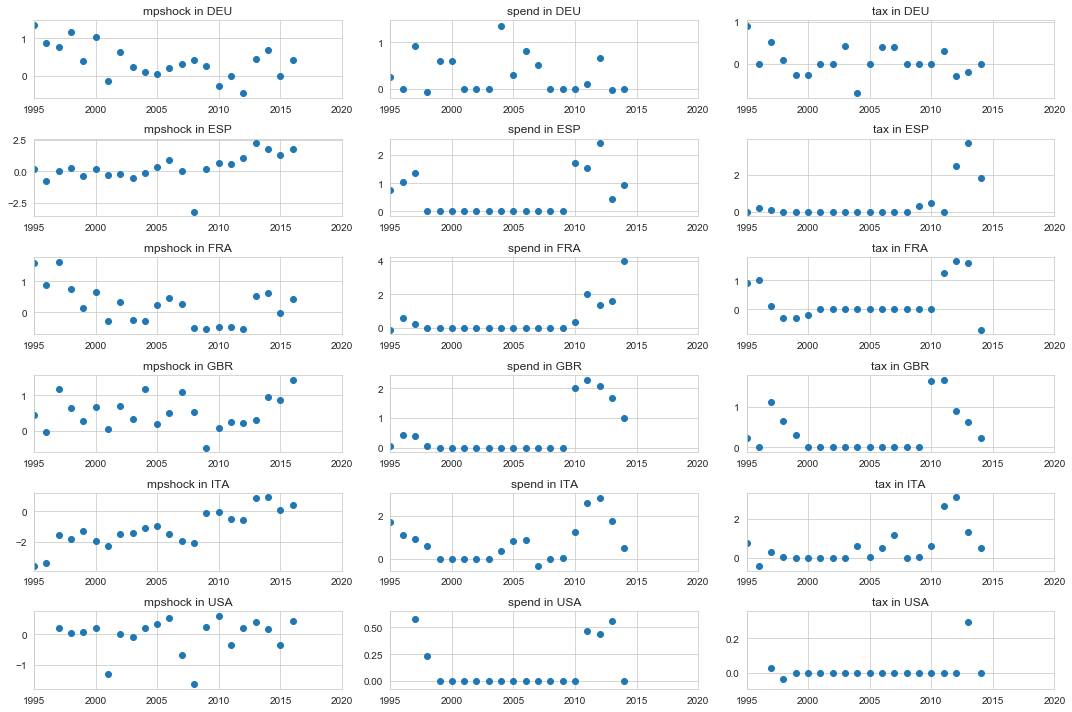

In [26]:
list_var = ["mpshock", "spend", "tax"]
nb_col = len(list_var)
nb_row = len(countries_selected)

fig = plt.figure(figsize=(15, 10))
id = 1
for country in countries_selected:
    table_country = table_desc[table_desc["iso3code"]==country]
    for variable in list_var:
        ax = fig.add_subplot(nb_row, nb_col, id)
        #ax.set_ylim(np.min(table_desc[variable]), np.max(table_desc[variable]))
        ax.set_xlim(1995, 2020)
        ax.set_title(variable+" in "+country)
        g = ax.scatter(table_country["year"], table_country[variable])
        id+=1
plt.tight_layout()

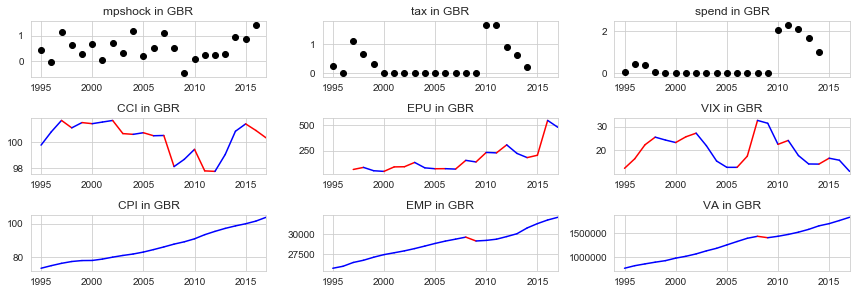

In [40]:
sns.set_style("whitegrid")
country = "GBR"
list_var = ["mpshock", "spend", "tax"]
nb_col = len(list_var)
nb_row = len(countries_selected)

fig = plt.figure(figsize=(12, 8))
id = 1

for variable in ["mpshock", "tax", "spend", "CCI", "EPU", "VIX", "CPI", "EMP", "VA"]:
    sub_table = table_desc[(table_desc["iso3code"]==country) & (table_desc[variable] is not None)]
    ax = fig.add_subplot(nb_row, nb_col, id)
    ax.set_xlim(1994, 2017)
    ax.set_title(variable+" in "+country)
    if id <=3:
        g = ax.scatter(sub_table["year"], sub_table[variable], color="black")
    else:
        for year in sub_table["year"].unique()[:-1]:
            current_value = sub_table[sub_table["year"]==year][variable].values[0]
            next_value = sub_table[sub_table["year"]==year+1][variable].values[0]
            if (next_value >= current_value) and (variable in ["EPU", "VIX"]) or ((next_value <= current_value) and (variable in ["CCI", "CPI", "EMP", "VA"])):
                color="red"
            else:
                color="blue"
            g = ax.plot([year, year+1], [current_value, next_value], color=color)
    id+=1
plt.tight_layout()

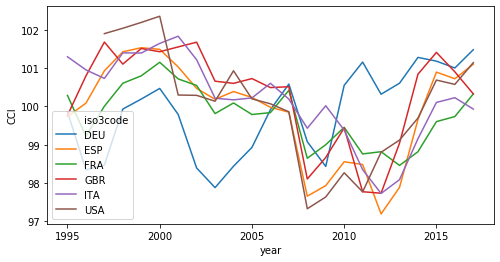

In [53]:
import seaborn as sns
fig = plt.figure(figsize=(8, 4))
sns.lineplot(x="year", y="CCI", hue="iso3code", data=table_desc)

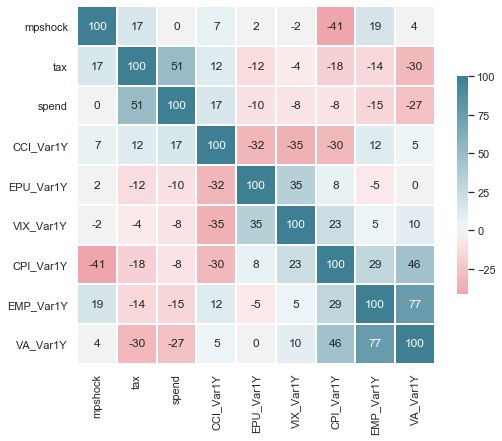

In [73]:
table_correlations = table_desc
for variable in ["CCI", "EPU", "VIX", "CPI", "EMP", "VA"]:
    column_retards = calcul_retards(table_correlations, 1, variable)
    table_correlations = table_correlations.merge(column_retards, on=["year", "iso3code", "code"], how="left")

table_correlations = table_correlations[["mpshock", "tax", "spend", "CCI_Var1Y", "EPU_Var1Y", "VIX_Var1Y", "CPI_Var1Y", "EMP_Var1Y", "VA_Var1Y"]]
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
corr = (table_correlations.corr()*100).astype(int)
cmap = sns.diverging_palette(10, 220, as_cmap=True)
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corr, cmap=cmap, center=0, square=True, annot=True, fmt="0", linewidths=1, cbar_kws={"shrink": .5}, annot_kws={"size": 12})
plt.show()

# Méthode de projection locale

In [55]:
variable_macro = "GO"
variable_choc = "mpshock"
variable_sentiment = "CCI"

disp_graph = True

sub_table = table_full.copy()
sub_table.head()

,iso3code,code,year,EMP,VA,CPI,EPU,BCI,CCI,VIX,tax,spend,mpshock
0,DEU,A,1995,866.0,17975.0,77.76434,82.524902,100.189685,99.860394,12.388770,0.91463,0.26111,1.351058
1,DEU,A,1996,809.0,19119.0,79.01445,94.398955,98.648056,98.338116,16.442165,0.00000,0.00000,0.875865
2,DEU,A,1997,785.0,19336.0,80.56599,79.234605,100.041146,98.469407,22.363984,0.53129,0.91382,0.760143
3,DEU,A,1998,779.0,18801.0,81.53912,88.340191,100.408232,99.932843,25.602976,0.10150,-0.07969,1.183405
4,DEU,A,1999,773.0,18850.0,82.04589,101.663260,99.290881,100.194154,24.372976,-0.24923,0.59173,0.381788


In [57]:
def calcul_betas(variable_macro, list_reg_choc, modele=1):
    betas = pd.DataFrame()
    
    for retard in range(1,5):
        regression_table = sub_table.copy()

        # Calcul des taux de croissance retardés
        column_retards = calcul_retards(regression_table, retard, variable_macro)
        regression_table = regression_table.merge(column_retards, on=["iso3code", "code", "year"], how="left")

        # Calcul de la colonne avec 1Y de décalage (pour rég sur l'an passé)
        column_retards_decalee = decalage(regression_table, 1, variable_macro+"_Var"+str(retard)+"Y")
        regression_table = regression_table.merge(column_retards_decalee, on=["iso3code", "code", "year"], how="left")
        
        # Calcul de la colonne avec 2Y de décalage (pour rég sur l'an passé)
        column_retards_decalee = decalage(regression_table, 2, variable_macro+"_Var"+str(retard)+"Y")
        regression_table = regression_table.merge(column_retards_decalee, on=["iso3code", "code", "year"], how="left")
        
        # Variable expliquée / variables explicatives
        list_variables_X = [variable_macro+"_Var"+str(retard)+"Y_decale1Y", variable_macro+"_Var"+str(retard)+"Y_decale2Y"] + list_reg_choc + list_reg_comp
        variable_Y = variable_macro+"_Var"+str(retard)+"Y"

        # Nettoyage de la table avant régression
        regression_table = regression_table[[variable_Y] + list_variables_X].dropna()
        Y = regression_table[variable_Y]
        X = regression_table[list_variables_X]
        #X = sm.add_constant(X)
        
        for column in X.columns:
            if np.sum(X[column]) == 0:
                del X[column]
        
        #regression_table.to_csv(str(retard)+variable_macro+variable_sentiment+variable_choc+".csv")
        
        # Régression et affichage si besoin
        model = OLS(Y,X)
        results = model.fit()
        
        # Enregistrement du log
        if modele==1:
            nom_fichier = "export_logs/"+str(modele)+"_repmoy_"+variable_choc+"_"+variable_macro+".txt"
        elif modele==4:
            nom_fichier = "export_logs/"+str(modele)+"_repmoy_"+iso3code+"_"+variable_choc+"_"+variable_macro+".txt"
        else:
            nom_fichier = "export_logs/"+str(modele)+"_"+variable_sentiment+"_"+variable_choc+"_"+variable_macro+".txt"
        
        if retard == 1: 
            fichier = open(nom_fichier, "w")
        else:
            fichier = open(nom_fichier, "a")
        fichier.write("\n\n"+str(results.summary()))
        fichier.close()

        # Création de la matrice des betas + intervalles de confiance
        conf_int = results.conf_int(alpha=0.1, cols=None).reset_index()
        params = pd.DataFrame(results.params).reset_index()
        params = params.merge(conf_int, how="left", on="index")
        params.columns=["index", "param", "borne_inf", "borne_sup"]
        params["amplitude"] = params["borne_sup"] - params["borne_inf"]
        params = params[params["index"].isin(list_reg_choc)]
        params["retard"] = retard
        betas = pd.concat([betas, params])
        
    return(betas)

In [55]:
def graphe_betas(betas, modele = 1):
    sns.set()
    fig, axs = plt.subplots()
    axs.axhline(0)
    axs.set_xlabel("Horizon en années")
    plt.title("Effet de "+variable_choc+" sur "+variable_macro)
    
    if modele == 1:
        axs.errorbar(betas["retard"], betas["param"], color="black", yerr=betas["amplitude"], fmt='o')
        plt.savefig("export_graphs/1_repmoy_"+variable_choc+"_"+variable_macro+".png")
    
    elif modele == 2:
        betas_bas = betas[betas["index"].str.contains("bas")].copy()
        betas_bas["retard"] = betas_bas["retard"] - 0.03
        g1 = axs.errorbar(betas_bas["retard"], betas_bas["param"], color="red", yerr=betas_bas["amplitude"], fmt='o')

        betas_haut = betas[betas["index"].str.contains("haut")].copy()
        betas_haut["retard"] = betas_haut["retard"] + 0.03
        g3 = axs.errorbar(betas_haut["retard"], betas_haut["param"], color="blue", yerr=betas_haut["amplitude"], fmt='o')

        plt.legend([g1, g3], [variable_sentiment + " bas", variable_sentiment + " haut"])
        plt.savefig("export_graphs/2_"+variable_sentiment+"_"+variable_choc+"_"+variable_macro+".png")
        
    elif modele == 3:
        confiance25 = np.percentile(sub_table[variable_sentiment].dropna(),25)
        confiance75 = np.percentile(sub_table[variable_sentiment].dropna(),75)
        g1 = axs.errorbar(betas["retard"] - 0.03, betas["param"]*confiance25, color="red", yerr=betas["amplitude"]*confiance25, fmt='o')
        g3 = axs.errorbar(betas["retard"] + 0.03, betas["param"]*confiance75, color="blue", yerr=betas["amplitude"]*confiance75, fmt='o')
        plt.legend([g1, g3], [variable_sentiment + " bas", variable_sentiment + " haut"])
        plt.savefig("export_graphs/3_"+variable_sentiment+"_"+variable_choc+"_"+variable_macro+".png")
        
    elif modele == 4:
        betas_DEU = betas[betas["index"].str.contains("DEU")].copy()
        g1 = axs.errorbar(betas_DEU["retard"]-0.09, betas_DEU["param"], color="b", yerr=betas_DEU["amplitude"], fmt='o')
        betas_ESP = betas[betas["index"].str.contains("ESP")].copy()
        g2 = axs.errorbar(betas_ESP["retard"]-0.06, betas_ESP["param"], color="g", yerr=betas_ESP["amplitude"], fmt='o')
        betas_FRA = betas[betas["index"].str.contains("FRA")].copy()
        g3 = axs.errorbar(betas_FRA["retard"]-0.03, betas_FRA["param"], color="r", yerr=betas_FRA["amplitude"], fmt='o')
        betas_GBR = betas[betas["index"].str.contains("GBR")].copy()
        g4 = axs.errorbar(betas_GBR["retard"]+0.03, betas_GBR["param"], color="c", yerr=betas_GBR["amplitude"], fmt='o')
        betas_ITA = betas[betas["index"].str.contains("ITA")].copy()
        g5 = axs.errorbar(betas_ITA["retard"]+0.06, betas_ITA["param"], color="m", yerr=betas_ITA["amplitude"], fmt='o')
        betas_USA = betas[betas["index"].str.contains("USA")].copy()
        g6 = axs.errorbar(betas_USA["retard"]+0.09, betas_USA["param"], color="k", yerr=betas_USA["amplitude"], fmt='o')
        plt.legend([g1, g2, g3, g4, g5, g6], ["DEU", "ESP", "FRA", "GBR", "ITA", "USA"])
        plt.savefig("export_graphs/4_repmoy_"+variable_choc+"_"+variable_macro+".png")
    plt.close()

## A. Réponse moyenne
$$\Delta_{c,s,t}^h = \gamma^h \Delta_{c,s,t-1}^h + \eta^h \Delta_{c,s,t-2}^h + \beta^h choc_{c,t} + \mu^h \mathbb{1}_{c} + \nu^h \mathbb{1}_s + \epsilon_{c,s,t}^h$$

Dans le cas où $h=1$, cela revient par exemple à écrire, pour une observation :
$$\frac{Y_{2002} - Y_{2001}}{Y_{2001}} = \gamma^1  \frac{Y_{2001} - Y_{2000}}{Y_{2000}} + \eta^1  \frac{Y_{2000} - Y_{1999}}{Y_{1999}} + \beta^1 choc_{2001} + \mu^1 \mathbb{1}_{Pays} + \nu^1 \mathbb{1}_{Secteur} + \epsilon^1_{2001}$$
On en déduit alors $\beta^1$ ainsi que l'IC associé.

Dans le cas où $h=2$, cela revient par exemple à écrire, pour une observation :
$$\frac{Y_{2003} - Y_{2001}}{Y_{2001}} = \gamma^2 \frac{Y_{2002} - Y_{2000}}{Y_{2000}} + \eta^2 \frac{Y_{2001} - Y_{1999}}{Y_{1999}} + \beta^2 choc_{2001} + \mu^2 \mathbb{1}_{Pays} + \nu^2 \mathbb{1}_{Secteur} + \epsilon^2_{2001}$$
On en déduit alors $\beta^2$ ainsi que l'IC associé.

Et ainsi de suite.

In [60]:
sub_table = table_full.copy()
list_reg_comp = []

for iso3code in sub_table["iso3code"].unique():
    sub_table["is_"+iso3code] = (sub_table["iso3code"]==iso3code)*1
    list_reg_comp.append("is_"+iso3code)

for code in sub_table["code"].unique():
    sub_table["is_code_"+code] = (sub_table["code"]==code)*1
    list_reg_comp.append("is_code_"+code)

for variable_macro in variables_EUKlems_selected:
    for variable_choc in ["mpshock", "tax", "spend"]:
        list_reg_choc = [variable_choc]
        betas = calcul_betas(variable_macro, list_reg_choc, modele=1)
        graphe_betas(betas, modele=1)

In [61]:
# Idem pour CPI

sub_table = table_full[table_full["code"]=="A"].copy()
list_reg_comp = []

for iso3code in sub_table["iso3code"].unique():
    sub_table["is_"+iso3code] = (sub_table["iso3code"]==iso3code)*1
    list_reg_comp.append("is_"+iso3code)

variable_macro = "CPI"
for variable_choc in ["mpshock", "tax", "spend"]:
    list_reg_choc = [variable_choc]
    betas = calcul_betas(variable_macro, list_reg_choc, modele=1)
    graphe_betas(betas, modele=1)

## A-bis. Réponse moyenne par pays

In [59]:
sub_table_full = table_full.copy()
list_reg_comp = []

for code in sub_table_full["code"].unique():
    sub_table_full["is_code_"+code] = (sub_table_full["code"]==code)*1
    list_reg_comp.append("is_code_"+code)

for variable_macro in variables_EUKlems_selected:
    for variable_choc in ["mpshock", "tax", "spend"]:
        list_reg_choc = [variable_choc]
        betas = pd.DataFrame()
        for iso3code in countries_selected:
            sub_table = sub_table_full[sub_table_full["iso3code"]==iso3code]
            betas_country = calcul_betas(variable_macro, list_reg_choc, modele=4)
            betas_country["index"] = betas_country["index"]+"_"+iso3code
            betas = pd.concat([betas, betas_country])
        graphe_betas(betas, modele=4)
        
# Idem pour CPI
list_reg_comp = []
for variable_macro in ["CPI"]:
    for variable_choc in ["mpshock", "tax", "spend"]:
        list_reg_choc = [variable_choc]
        betas = pd.DataFrame()
        for iso3code in countries_selected:
            sub_table = sub_table_full[sub_table_full["iso3code"]==iso3code]
            betas_country = calcul_betas(variable_macro, list_reg_choc, modele=4)
            betas_country["index"] = betas_country["index"]+"_"+iso3code
            betas = pd.concat([betas, betas_country])
        graphe_betas(betas, modele=4)

## B. By bins
$$\Delta_{c,s,t}^h = \gamma^h \Delta_{c,s,t-1}^h + \eta^h \Delta_{c,s,t-2}^h + \beta^h_{ConfBasse} choc_{c,t} . \mathbb{1}_{ConfBasse} + \beta^h_{ConfMoy} choc_{c,t} . \mathbb{1}_{ConfMoy} + \beta^h_{ConfHaute} choc_{c,t} . \mathbb{1}_{ConfHaute} + \mu^h \mathbb{1}_{c,t} + \nu^h \mathbb{1}_{s,t} + \epsilon^h_{c,s,t}$$

In [36]:
sub_table = table_full.copy()
list_reg_comp = []
init = 0
for iso3code in sub_table["iso3code"].unique():
    for year in sub_table["year"].unique():
        variable = "is_"+iso3code+"_"+str(year)
        sub_table[variable] = (sub_table["iso3code"]==iso3code)*1*(sub_table["year"]==year)
        list_reg_comp.append(variable)

for code in sub_table["code"].unique():
    for year in sub_table["year"].unique():
        variable = "is_"+code+"_"+str(year)
        sub_table[variable] = (sub_table["code"]==code)*1*(sub_table["year"]==year)
        list_reg_comp.append(variable)

np.seterr(divide='ignore', invalid='ignore')
for variable_sentiment in ["CCI", "EPU", "VIX"]:
    valeurs_seuil = pd.DataFrame(columns=["iso3code", "val_basse_"+variable_sentiment, "val_haute_"+variable_sentiment])
    for iso3code in sub_table["iso3code"].unique():
        table_country = sub_table[sub_table["iso3code"]==iso3code]
        val_basse = np.percentile(table_country[variable_sentiment].dropna(), 25)
        val_haute = np.percentile(table_country[variable_sentiment].dropna(), 75)
        valeurs_seuil.loc[len(valeurs_seuil)] = [iso3code, val_basse, val_haute]
    sub_table = sub_table.merge(valeurs_seuil, on="iso3code")
    
    for variable_choc in ["mpshock", "spend", "tax"]:
        sub_table[variable_choc+"*"+variable_sentiment+"_bas"] = sub_table[variable_choc] * ((sub_table[variable_sentiment] <= sub_table["val_basse_"+variable_sentiment])*1)
        sub_table[variable_choc+"*"+variable_sentiment+"_haut"] = sub_table[variable_choc] * ((sub_table[variable_sentiment] >= sub_table["val_haute_"+variable_sentiment])*1)

        list_reg_choc = []
        list_reg_choc.append(variable_choc+"*"+variable_sentiment+"_bas")
        list_reg_choc.append(variable_choc+"*"+variable_sentiment+"_haut")

        for variable_macro in variables_EUKlems_selected:
            betas = calcul_betas(variable_macro, list_reg_choc, modele=2)
            graphe_betas(betas, modele = 2)

In [37]:
# Idem pour CPI

sub_table = table_full[table_full["code"]=="A"].copy()
list_reg_comp = []

for iso3code in sub_table["iso3code"].unique():
    sub_table["is_"+iso3code] = (sub_table["iso3code"]==iso3code)*1
    list_reg_comp.append("is_"+iso3code)
    
for year in sub_table["year"].unique():
    sub_table["is_"+str(year)] = (sub_table["year"]==str(year))*1
    list_reg_comp.append("is_"+str(year))

np.seterr(divide='ignore', invalid='ignore')
for variable_sentiment in ["CCI", "EPU", "VIX"]:
    valeurs_seuil = pd.DataFrame(columns=["iso3code", "val_basse_"+variable_sentiment, "val_haute_"+variable_sentiment])
    for iso3code in sub_table["iso3code"].unique():
        table_country = sub_table[sub_table["iso3code"]==iso3code]
        val_basse = np.percentile(table_country[variable_sentiment].dropna(), 25)
        val_haute = np.percentile(table_country[variable_sentiment].dropna(), 75)
        valeurs_seuil.loc[len(valeurs_seuil)] = [iso3code, val_basse, val_haute]
    sub_table = sub_table.merge(valeurs_seuil, on="iso3code")
    
    variable_macro = "CPI"
    for variable_choc in ["mpshock", "spend", "tax"]:
        sub_table[variable_choc+"*"+variable_sentiment+"_bas"] = sub_table[variable_choc] * ((sub_table[variable_sentiment] <= sub_table["val_basse_"+variable_sentiment])*1)
        sub_table[variable_choc+"*"+variable_sentiment+"_haut"] = sub_table[variable_choc] * ((sub_table[variable_sentiment] >= sub_table["val_haute_"+variable_sentiment])*1)

        list_reg_choc = []
        list_reg_choc.append(variable_choc+"*"+variable_sentiment+"_bas")
        list_reg_choc.append(variable_choc+"*"+variable_sentiment+"_haut")

        betas = calcul_betas(variable_macro, list_reg_choc, modele=2)
        graphe_betas(betas, modele = 2)

## C. Confiance en niveau
$$\Delta_{c,s,t}^h = \alpha^h + \gamma^h \Delta_{c,s,t-1}^h + \eta^h \Delta_{c,s,t-2}^h + \beta^h choc_{c,t} . confiance_{c,t} + \mu^h \mathbb{1}_{c, t} + \nu^h \mathbb{1}_{s, t} + \epsilon^h_{c,s,t}$$

In [38]:
sub_table = table_full.copy()

list_reg_comp = []

for iso3code in sub_table["iso3code"].unique():
    for year in sub_table["year"].unique():
        variable = "is_"+iso3code+"_"+str(year)
        sub_table[variable] = (sub_table["iso3code"]==iso3code)*1*(sub_table["year"]==year)
        list_reg_comp.append(variable)

for code in sub_table["code"].unique():
    for year in sub_table["year"].unique():
        variable = "is_"+code+"_"+str(year)
        sub_table[variable] = (sub_table["code"]==code)*1*(sub_table["year"]==year)
        list_reg_comp.append(variable)
    
np.seterr(divide='ignore', invalid='ignore')
for variable_sentiment in ["CCI", "EPU", "VIX"]:
    for variable_macro in variables_EUKlems_selected:
        for variable_choc in ["mpshock", "spend", "tax"]:
            list_reg_choc = [variable_choc+"*"+variable_sentiment]
            sub_table[variable_choc+"*"+variable_sentiment] = sub_table[variable_choc] * sub_table[variable_sentiment]
            betas = calcul_betas(variable_macro, list_reg_choc, modele=3)
            graphe_betas(betas, modele=3)

In [39]:
# Idem pour CPI

sub_table = table_full[table_full["code"]=="A"].copy()

list_reg_comp = []
for iso3code in sub_table["iso3code"].unique():
    sub_table["is_"+iso3code] = (sub_table["iso3code"]==iso3code)*1
    list_reg_comp.append("is_"+iso3code)
    
for year in sub_table["year"].unique():
    sub_table["is_"+str(year)] = (sub_table["year"]==str(year))*1
    list_reg_comp.append("is_"+str(year))
    
np.seterr(divide='ignore', invalid='ignore')
variable_macro = "CPI"
for variable_sentiment in ["CCI", "EPU", "VIX"]:
    for variable_choc in ["mpshock", "spend", "tax"]:
        list_reg_choc = [variable_choc+"*"+variable_sentiment]
        sub_table[variable_choc+"*"+variable_sentiment] = sub_table[variable_choc] * sub_table[variable_sentiment]
        betas = calcul_betas(variable_macro, list_reg_choc, modele=3)
        graphe_betas(betas, modele=3)
